In [615]:
import pandas as pd
import numpy as np
import re
import math

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import natural language processing libraries
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Model selection libraries
from sklearn.model_selection import train_test_split, GridSearchCV

# Processing libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Modeling libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB

# Model Evaluation Libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import Dimensionality Reduction libraries
from sklearn.decomposition import PCA

# Import pipeline library
from sklearn.pipeline import Pipeline

from tempfile import mkdtemp

In [381]:
# Import warnings and supress them
import warnings
warnings.filterwarnings('ignore')

In [382]:
# Configure Pandas to show all columns / rows
pd.options.display.max_columns = 2000
pd.options.display.max_rows = 2000
# Set column max width larger
pd.set_option('display.max_colwidth', 200)

In [585]:
# Set up matplotlib to use nice styles
plt.style.use('ggplot')

In [732]:
# import the nltk stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords 

ENGLISH_STOP_WORDS = stopwords.words('english')
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rosswillett/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [733]:
def custom_tokenizer(text):
    # allow alphabetical characters and spaces only
    processed_text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Filter out additional spaces
    processed_text = re.sub(r'\s\s*', ' ', processed_text)
    
    # split sentence into words
    listofwords = processed_text.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

In [722]:
# Load data from phishing email csv
email_df = pd.read_csv('./data/phishing_all_data_clean_4.csv')

In [723]:
email_df.shape

(12401, 6)

In [724]:
email_df['phishing'].value_counts()

0    6743
1    5658
Name: phishing, dtype: int64

In [725]:
X = email_df.drop(columns=['phishing'])
y = email_df.loc[:, ['phishing']]

In [726]:
X_remainder, X_test, y_remainder, y_test = train_test_split(
    X,
    y,
    stratify=y,
    random_state=1337,
    test_size=0.2,
)
X_remainder.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_remainder.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [727]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X_remainder,
    y_remainder,
    stratify=y_remainder,
    random_state=1337,
    test_size=0.2,
)
X_train.reset_index(drop=True, inplace=True)
X_validation.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_validation.reset_index(drop=True, inplace=True)

In [728]:
y_train

,phishing
0,0
1,0
2,0
3,1
4,1
...,...
7931,0
7932,1
7933,0
7934,1


## Vectorize All Emails

## Building Initial Models

### Vectorize Columns

In [767]:
cv_transf = ColumnTransformer([
        (
            'count_vectorizer',
            CountVectorizer(
                tokenizer=custom_tokenizer,
                min_df=0.05
            ),
            'content',
        )
    ],
    remainder='passthrough'
)

In [768]:
X_train_vec = cv_transf.fit_transform(X_train)

In [769]:
X_train_vec = pd.DataFrame(
    data=X_train_vec.toarray(),
    columns=cv_transf.get_feature_names_out(),
)
X_train_vec.head(10)

,count_vectorizer__abl,count_vectorizer__accept,count_vectorizer__access,count_vectorizer__accord,count_vectorizer__account,count_vectorizer__actual,count_vectorizer__address,count_vectorizer__agre,count_vectorizer__agreement,count_vectorizer__along,count_vectorizer__also,count_vectorizer__amount,count_vectorizer__anoth,count_vectorizer__arrang,count_vectorizer__ask,count_vectorizer__assist,count_vectorizer__assur,count_vectorizer__attent,count_vectorizer__back,count_vectorizer__bank,count_vectorizer__base,count_vectorizer__behalf,count_vectorizer__believ,count_vectorizer__beneficiari,count_vectorizer__best,count_vectorizer__bless,count_vectorizer__busi,count_vectorizer__call,count_vectorizer__care,count_vectorizer__case,count_vectorizer__chang,count_vectorizer__choos,count_vectorizer__claim,count_vectorizer__click,count_vectorizer__client,count_vectorizer__close,count_vectorizer__come,count_vectorizer__commun,count_vectorizer__compani,count_vectorizer__complet,count_vectorizer__concern,count_vectorizer__confid,count_vectorizer__confidenti,count_vectorizer__confirm,count_vectorizer__contact,count_vectorizer__corpor,count_vectorizer__could,count_vectorizer__countri,count_vectorizer__cours,count_vectorizer__current,count_vectorizer__custom,count_vectorizer__day,count_vectorizer__deal,count_vectorizer__dear,count_vectorizer__death,count_vectorizer__deceas,count_vectorizer__decid,count_vectorizer__depart,count_vectorizer__deposit,count_vectorizer__develop,count_vectorizer__direct,count_vectorizer__discov,count_vectorizer__discuss,count_vectorizer__done,count_vectorizer__due,count_vectorizer__easi,count_vectorizer__enabl,count_vectorizer__end,count_vectorizer__even,count_vectorizer__everi,count_vectorizer__execut,count_vectorizer__fact,count_vectorizer__faith,count_vectorizer__famili,count_vectorizer__father,count_vectorizer__file,count_vectorizer__final,count_vectorizer__financi,count_vectorizer__find,count_vectorizer__first,count_vectorizer__five,count_vectorizer__follow,count_vectorizer__foreign,count_vectorizer__form,count_vectorizer__former,count_vectorizer__forward,count_vectorizer__free,count_vectorizer__friend,count_vectorizer__full,count_vectorizer__fund,count_vectorizer__futur,count_vectorizer__gener,count_vectorizer__get,count_vectorizer__give,count_vectorizer__given,count_vectorizer__go,count_vectorizer__god,count_vectorizer__good,count_vectorizer__got,count_vectorizer__govern,count_vectorizer__great,count_vectorizer__group,count_vectorizer__hear,count_vectorizer__help,count_vectorizer__henc,count_vectorizer__home,count_vectorizer__hope,count_vectorizer__hous,count_vectorizer__howev,count_vectorizer__hundr,count_vectorizer__id,count_vectorizer__immedi,count_vectorizer__import,count_vectorizer__includ,count_vectorizer__inform,count_vectorizer__interest,count_vectorizer__intern,count_vectorizer__invest,count_vectorizer__involv,count_vectorizer__issu,count_vectorizer__keep,count_vectorizer__kin,count_vectorizer__know,count_vectorizer__last,count_vectorizer__late,count_vectorizer__law,count_vectorizer__leav,count_vectorizer__left,count_vectorizer__legal,count_vectorizer__let,count_vectorizer__letter,count_vectorizer__life,count_vectorizer__like,count_vectorizer__link,count_vectorizer__list,count_vectorizer__live,count_vectorizer__long,count_vectorizer__look,count_vectorizer__made,count_vectorizer__mail,count_vectorizer__mailman,count_vectorizer__make,count_vectorizer__manag,count_vectorizer__mani,count_vectorizer__matter,count_vectorizer__may,count_vectorizer__meet,count_vectorizer__member,count_vectorizer__messag,count_vectorizer__might,count_vectorizer__million,count_vectorizer__money,count_vectorizer__move,count_vectorizer__much,count_vectorizer__must,count_vectorizer__name,count_vectorizer__nation,count_vectorizer__necessari,count_vectorizer__need,count_vectorizer__net,count_vectorizer__never,count_vectorizer__new,count_vectorizer__next,count_vectorizer__note,count_vectorizer__number,count_vectorizer__offer,count_vector

In [770]:
X_train_vec.shape

(7936, 283)

In [771]:
X_validation_vec = cv_transf.transform(X_validation)
X_validation_vec = pd.DataFrame(
    data=X_validation_vec.toarray(),
    columns=cv_transf.get_feature_names_out(),
)
X_validation_vec.head(10)

,count_vectorizer__abl,count_vectorizer__accept,count_vectorizer__access,count_vectorizer__accord,count_vectorizer__account,count_vectorizer__actual,count_vectorizer__address,count_vectorizer__agre,count_vectorizer__agreement,count_vectorizer__along,count_vectorizer__also,count_vectorizer__amount,count_vectorizer__anoth,count_vectorizer__arrang,count_vectorizer__ask,count_vectorizer__assist,count_vectorizer__assur,count_vectorizer__attent,count_vectorizer__back,count_vectorizer__bank,count_vectorizer__base,count_vectorizer__behalf,count_vectorizer__believ,count_vectorizer__beneficiari,count_vectorizer__best,count_vectorizer__bless,count_vectorizer__busi,count_vectorizer__call,count_vectorizer__care,count_vectorizer__case,count_vectorizer__chang,count_vectorizer__choos,count_vectorizer__claim,count_vectorizer__click,count_vectorizer__client,count_vectorizer__close,count_vectorizer__come,count_vectorizer__commun,count_vectorizer__compani,count_vectorizer__complet,count_vectorizer__concern,count_vectorizer__confid,count_vectorizer__confidenti,count_vectorizer__confirm,count_vectorizer__contact,count_vectorizer__corpor,count_vectorizer__could,count_vectorizer__countri,count_vectorizer__cours,count_vectorizer__current,count_vectorizer__custom,count_vectorizer__day,count_vectorizer__deal,count_vectorizer__dear,count_vectorizer__death,count_vectorizer__deceas,count_vectorizer__decid,count_vectorizer__depart,count_vectorizer__deposit,count_vectorizer__develop,count_vectorizer__direct,count_vectorizer__discov,count_vectorizer__discuss,count_vectorizer__done,count_vectorizer__due,count_vectorizer__easi,count_vectorizer__enabl,count_vectorizer__end,count_vectorizer__even,count_vectorizer__everi,count_vectorizer__execut,count_vectorizer__fact,count_vectorizer__faith,count_vectorizer__famili,count_vectorizer__father,count_vectorizer__file,count_vectorizer__final,count_vectorizer__financi,count_vectorizer__find,count_vectorizer__first,count_vectorizer__five,count_vectorizer__follow,count_vectorizer__foreign,count_vectorizer__form,count_vectorizer__former,count_vectorizer__forward,count_vectorizer__free,count_vectorizer__friend,count_vectorizer__full,count_vectorizer__fund,count_vectorizer__futur,count_vectorizer__gener,count_vectorizer__get,count_vectorizer__give,count_vectorizer__given,count_vectorizer__go,count_vectorizer__god,count_vectorizer__good,count_vectorizer__got,count_vectorizer__govern,count_vectorizer__great,count_vectorizer__group,count_vectorizer__hear,count_vectorizer__help,count_vectorizer__henc,count_vectorizer__home,count_vectorizer__hope,count_vectorizer__hous,count_vectorizer__howev,count_vectorizer__hundr,count_vectorizer__id,count_vectorizer__immedi,count_vectorizer__import,count_vectorizer__includ,count_vectorizer__inform,count_vectorizer__interest,count_vectorizer__intern,count_vectorizer__invest,count_vectorizer__involv,count_vectorizer__issu,count_vectorizer__keep,count_vectorizer__kin,count_vectorizer__know,count_vectorizer__last,count_vectorizer__late,count_vectorizer__law,count_vectorizer__leav,count_vectorizer__left,count_vectorizer__legal,count_vectorizer__let,count_vectorizer__letter,count_vectorizer__life,count_vectorizer__like,count_vectorizer__link,count_vectorizer__list,count_vectorizer__live,count_vectorizer__long,count_vectorizer__look,count_vectorizer__made,count_vectorizer__mail,count_vectorizer__mailman,count_vectorizer__make,count_vectorizer__manag,count_vectorizer__mani,count_vectorizer__matter,count_vectorizer__may,count_vectorizer__meet,count_vectorizer__member,count_vectorizer__messag,count_vectorizer__might,count_vectorizer__million,count_vectorizer__money,count_vectorizer__move,count_vectorizer__much,count_vectorizer__must,count_vectorizer__name,count_vectorizer__nation,count_vectorizer__necessari,count_vectorizer__need,count_vectorizer__net,count_vectorizer__never,count_vectorizer__new,count_vectorizer__next,count_vectorizer__note,count_vectorizer__number,count_vectorizer__offer,count_vector

In [772]:
X_validation_vec.shape

(1984, 283)

### PCA Comparison

In [773]:
pca = PCA(n_components=4)

In [774]:
X_pca = pca.fit_transform(X_train_vec)

<Figure size 1500x1000 with 0 Axes>

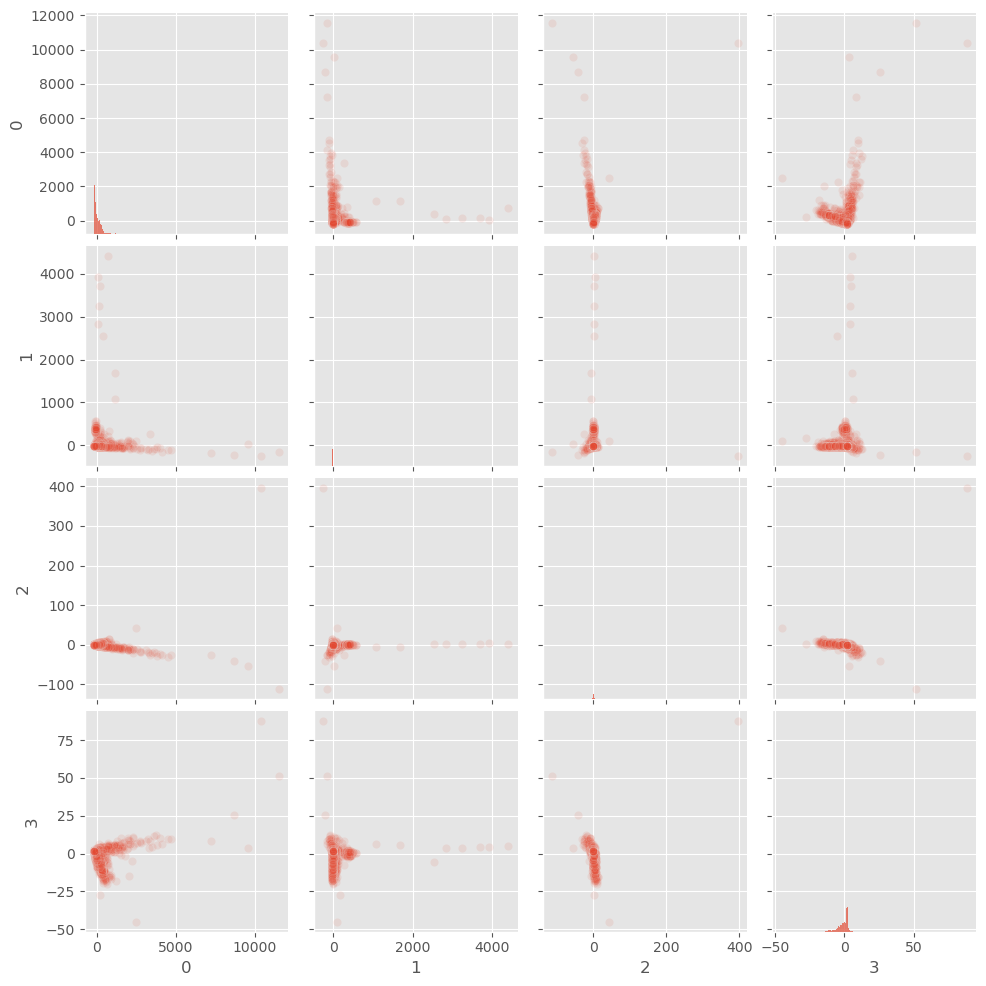

In [775]:
plt.figure(figsize=(15,10))
sns.pairplot(pd.DataFrame(X_pca), kind='scatter', plot_kws={'alpha':0.1})
plt.show()

### Model Building

In [779]:
results_dict = {
    'Model': [],
    'Train Accuracy': [],
    'Validation Accuracy': [],
}

In [780]:
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train_vec, y_train)
log_reg_train_acc = log_reg_model.score(X_train_vec, y_train) * 100
print(log_reg_train_acc)

97.20262096774194


In [781]:
log_reg_val_acc = log_reg_model.score(X_validation_vec, y_validation) * 100
print(log_reg_val_acc)

96.92540322580645


In [782]:
results_dict['Model'].append('Logistic Regression')
results_dict['Train Accuracy'].append(log_reg_train_acc)
results_dict['Validation Accuracy'].append(log_reg_val_acc)

In [783]:
log_reg_coef_pd = pd.DataFrame(log_reg_model.coef_, columns=X_train_vec.columns, index=['Coefficient']).T

In [784]:
log_reg_coef_pd.sort_values(by='Coefficient', ascending=False).head(20)

,Coefficient
count_vectorizer__bank,2.138286
count_vectorizer__yahoo,1.916926
count_vectorizer__account,1.879155
count_vectorizer__transact,1.791473
count_vectorizer__money,1.733199
count_vectorizer__dear,1.722245
count_vectorizer__god,1.532576
count_vectorizer__fund,1.345040
count_vectorizer__pleas,1.241014
count_vectorizer__name,1.239202


In [785]:
log_reg_coef_pd.sort_values(by='Coefficient', ascending=True).head(20)

,Coefficient
count_vectorizer__state,-1.900655
count_vectorizer__call,-1.034994
count_vectorizer__mailman,-1.017628
count_vectorizer__meet,-0.970735
count_vectorizer__said,-0.968500
count_vectorizer__see,-0.965987
count_vectorizer__like,-0.960457
count_vectorizer__follow,-0.958958
count_vectorizer__releas,-0.931082
count_vectorizer__group,-0.874493


In [786]:
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(X_train_vec)
x_mm_scaled_vec = minMaxScaler.transform(X_train_vec)
knn_model = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn_model.fit(x_mm_scaled_vec, y_train)
knn_train_acc = knn_model.score(x_mm_scaled_vec, y_train) * 100
print(knn_train_acc)

96.01814516129032


In [787]:
x_mm_scaled_vec = minMaxScaler.transform(X_validation_vec)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_mm_scaled_vec, y_validation)
knn_val_acc = knn_model.score(x_mm_scaled_vec, y_validation) * 100
print(knn_val_acc)

91.98588709677419


In [788]:
results_dict['Model'].append('KNN (Cosine Similarity)')
results_dict['Train Accuracy'].append(knn_train_acc)
results_dict['Validation Accuracy'].append(knn_val_acc)

In [789]:
dec_tree_model = DecisionTreeClassifier()
dec_tree_model.fit(X_train_vec, y_train)
dt_train_acc = dec_tree_model.score(X_train_vec, y_train) * 100
print(dt_train_acc)

99.92439516129032


In [790]:
dt_val_acc = dec_tree_model.score(X_validation_vec, y_validation) * 100
print(dt_val_acc)

94.05241935483872


In [791]:
results_dict['Model'].append('Decision Tree')
results_dict['Train Accuracy'].append(dt_train_acc)
results_dict['Validation Accuracy'].append(dt_val_acc)

In [792]:
nb_model = BernoulliNB()
nb_model.fit(X_train_vec, y_train)
nb_train_acc = nb_model.score(X_train_vec, y_train) * 100
print(nb_train_acc)

89.33971774193549


In [793]:
nb_test_acc = nb_model.score(X_validation_vec, y_validation) * 100
print(nb_test_acc)

88.91129032258065


In [794]:
results_dict['Model'].append('Naive Bayes')
results_dict['Train Accuracy'].append(nb_train_acc)
results_dict['Validation Accuracy'].append(nb_test_acc)

In [795]:
results_df = pd.DataFrame(results_dict)

In [798]:
results_df

,Model,Train Accuracy,Validation Accuracy
0,Logistic Regression,97.202621,96.925403
1,KNN (Cosine Similarity),96.018145,91.985887
2,Decision Tree,99.924395,94.052419
3,Naive Bayes,89.339718,88.911290


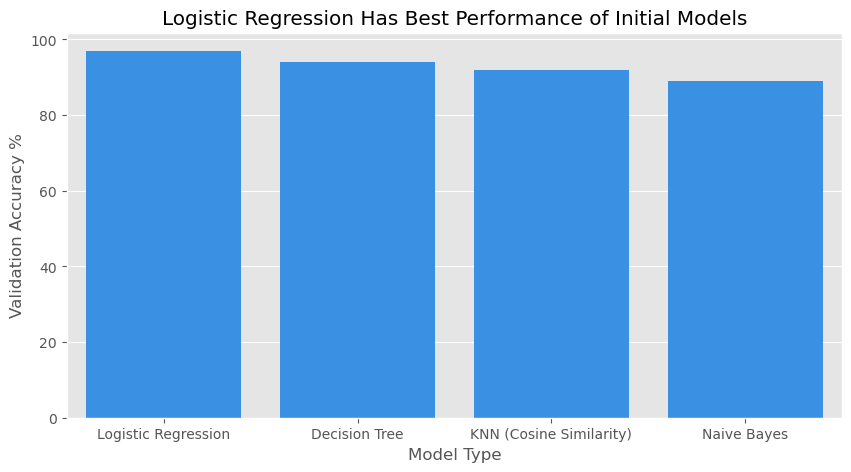

In [796]:
plt.figure(figsize=(10,5))
mod_perf_fig = sns.barplot(
    x='Model',
    y='Validation Accuracy',
    data=results_df.sort_values('Validation Accuracy', ascending=False),
    color='dodgerblue'
)
plt.title('Logistic Regression Has Best Performance of Initial Models')
plt.xlabel('Model Type')
plt.ylabel('Validation Accuracy %')
plt.show()

In [797]:
mod_perf_fig.figure.savefig('model_perf', bbox_inches="tight")

### TFIDF

In [453]:
tfidf_transf = ColumnTransformer([
        (
            'tfidf_vectorizer',
            TfidfVectorizer(
                tokenizer=custom_tokenizer,
                min_df=0.05
            ),
            'content',
        )
    ],
    remainder='passthrough'
)

In [454]:
X_train_tfidf = tfidf_transf.fit_transform(X_train)

In [455]:
X_train_tfidf = pd.DataFrame(
    data=X_train_tfidf.toarray(),
    columns=cv_transf.get_feature_names_out(),
)
X_train_tfidf.head(10)

,count_vectorizer__abl,count_vectorizer__accept,count_vectorizer__access,count_vectorizer__accord,count_vectorizer__account,count_vectorizer__address,count_vectorizer__agre,count_vectorizer__agreement,count_vectorizer__also,count_vectorizer__amount,count_vectorizer__anoth,count_vectorizer__arrang,count_vectorizer__ask,count_vectorizer__assist,count_vectorizer__assur,count_vectorizer__attent,count_vectorizer__back,count_vectorizer__bank,count_vectorizer__base,count_vectorizer__believ,count_vectorizer__beneficiari,count_vectorizer__best,count_vectorizer__better,count_vectorizer__bless,count_vectorizer__busi,count_vectorizer__call,count_vectorizer__care,count_vectorizer__choos,count_vectorizer__claim,count_vectorizer__click,count_vectorizer__client,count_vectorizer__come,count_vectorizer__commun,count_vectorizer__compani,count_vectorizer__complet,count_vectorizer__confid,count_vectorizer__confidenti,count_vectorizer__confirm,count_vectorizer__contact,count_vectorizer__corpor,count_vectorizer__could,count_vectorizer__countri,count_vectorizer__current,count_vectorizer__custom,count_vectorizer__day,count_vectorizer__deal,count_vectorizer__dear,count_vectorizer__death,count_vectorizer__deceas,count_vectorizer__decid,count_vectorizer__depart,count_vectorizer__deposit,count_vectorizer__direct,count_vectorizer__discov,count_vectorizer__discuss,count_vectorizer__due,count_vectorizer__easi,count_vectorizer__enabl,count_vectorizer__end,count_vectorizer__even,count_vectorizer__everi,count_vectorizer__execut,count_vectorizer__fact,count_vectorizer__faith,count_vectorizer__famili,count_vectorizer__father,count_vectorizer__file,count_vectorizer__final,count_vectorizer__financi,count_vectorizer__find,count_vectorizer__first,count_vectorizer__five,count_vectorizer__follow,count_vectorizer__foreign,count_vectorizer__form,count_vectorizer__former,count_vectorizer__forward,count_vectorizer__free,count_vectorizer__friend,count_vectorizer__full,count_vectorizer__fund,count_vectorizer__futur,count_vectorizer__gener,count_vectorizer__get,count_vectorizer__give,count_vectorizer__go,count_vectorizer__god,count_vectorizer__good,count_vectorizer__got,count_vectorizer__govern,count_vectorizer__great,count_vectorizer__group,count_vectorizer__hear,count_vectorizer__help,count_vectorizer__henc,count_vectorizer__home,count_vectorizer__hope,count_vectorizer__hous,count_vectorizer__howev,count_vectorizer__hundr,count_vectorizer__id,count_vectorizer__immedi,count_vectorizer__import,count_vectorizer__includ,count_vectorizer__inform,count_vectorizer__interest,count_vectorizer__intern,count_vectorizer__invest,count_vectorizer__involv,count_vectorizer__issu,count_vectorizer__keep,count_vectorizer__kin,count_vectorizer__know,count_vectorizer__last,count_vectorizer__late,count_vectorizer__law,count_vectorizer__leav,count_vectorizer__left,count_vectorizer__let,count_vectorizer__letter,count_vectorizer__life,count_vectorizer__like,count_vectorizer__link,count_vectorizer__list,count_vectorizer__live,count_vectorizer__long,count_vectorizer__look,count_vectorizer__made,count_vectorizer__mail,count_vectorizer__mailman,count_vectorizer__make,count_vectorizer__manag,count_vectorizer__mani,count_vectorizer__matter,count_vectorizer__may,count_vectorizer__meet,count_vectorizer__member,count_vectorizer__messag,count_vectorizer__might,count_vectorizer__million,count_vectorizer__money,count_vectorizer__move,count_vectorizer__much,count_vectorizer__must,count_vectorizer__name,count_vectorizer__nation,count_vectorizer__necessari,count_vectorizer__need,count_vectorizer__net,count_vectorizer__never,count_vectorizer__new,count_vectorizer__next,count_vectorizer__note,count_vectorizer__number,count_vectorizer__offer,count_vectorizer__offic,count_vectorizer__offici,count_vectorizer__old,count_vectorizer__one,count_vectorizer__open,count_vectorizer__oper,count_vectorizer__order,count_vectorizer__part,count_vectorizer__partner,count_vectorizer__peopl,count_vectorizer__person,count_vectorizer__

In [456]:
X_train_tfidf.shape

(8278, 265)

In [459]:
X_validation_tfidf = cv_transf.transform(X_validation)
X_validation_tfidf = pd.DataFrame(
    data=X_validation_tfidf.toarray(),
    columns=cv_transf.get_feature_names_out(),
)
X_validation_tfidf.head(10)

,count_vectorizer__abl,count_vectorizer__accept,count_vectorizer__access,count_vectorizer__accord,count_vectorizer__account,count_vectorizer__address,count_vectorizer__agre,count_vectorizer__agreement,count_vectorizer__also,count_vectorizer__amount,count_vectorizer__anoth,count_vectorizer__arrang,count_vectorizer__ask,count_vectorizer__assist,count_vectorizer__assur,count_vectorizer__attent,count_vectorizer__back,count_vectorizer__bank,count_vectorizer__base,count_vectorizer__believ,count_vectorizer__beneficiari,count_vectorizer__best,count_vectorizer__better,count_vectorizer__bless,count_vectorizer__busi,count_vectorizer__call,count_vectorizer__care,count_vectorizer__choos,count_vectorizer__claim,count_vectorizer__click,count_vectorizer__client,count_vectorizer__come,count_vectorizer__commun,count_vectorizer__compani,count_vectorizer__complet,count_vectorizer__confid,count_vectorizer__confidenti,count_vectorizer__confirm,count_vectorizer__contact,count_vectorizer__corpor,count_vectorizer__could,count_vectorizer__countri,count_vectorizer__current,count_vectorizer__custom,count_vectorizer__day,count_vectorizer__deal,count_vectorizer__dear,count_vectorizer__death,count_vectorizer__deceas,count_vectorizer__decid,count_vectorizer__depart,count_vectorizer__deposit,count_vectorizer__direct,count_vectorizer__discov,count_vectorizer__discuss,count_vectorizer__due,count_vectorizer__easi,count_vectorizer__enabl,count_vectorizer__end,count_vectorizer__even,count_vectorizer__everi,count_vectorizer__execut,count_vectorizer__fact,count_vectorizer__faith,count_vectorizer__famili,count_vectorizer__father,count_vectorizer__file,count_vectorizer__final,count_vectorizer__financi,count_vectorizer__find,count_vectorizer__first,count_vectorizer__five,count_vectorizer__follow,count_vectorizer__foreign,count_vectorizer__form,count_vectorizer__former,count_vectorizer__forward,count_vectorizer__free,count_vectorizer__friend,count_vectorizer__full,count_vectorizer__fund,count_vectorizer__futur,count_vectorizer__gener,count_vectorizer__get,count_vectorizer__give,count_vectorizer__go,count_vectorizer__god,count_vectorizer__good,count_vectorizer__got,count_vectorizer__govern,count_vectorizer__great,count_vectorizer__group,count_vectorizer__hear,count_vectorizer__help,count_vectorizer__henc,count_vectorizer__home,count_vectorizer__hope,count_vectorizer__hous,count_vectorizer__howev,count_vectorizer__hundr,count_vectorizer__id,count_vectorizer__immedi,count_vectorizer__import,count_vectorizer__includ,count_vectorizer__inform,count_vectorizer__interest,count_vectorizer__intern,count_vectorizer__invest,count_vectorizer__involv,count_vectorizer__issu,count_vectorizer__keep,count_vectorizer__kin,count_vectorizer__know,count_vectorizer__last,count_vectorizer__late,count_vectorizer__law,count_vectorizer__leav,count_vectorizer__left,count_vectorizer__let,count_vectorizer__letter,count_vectorizer__life,count_vectorizer__like,count_vectorizer__link,count_vectorizer__list,count_vectorizer__live,count_vectorizer__long,count_vectorizer__look,count_vectorizer__made,count_vectorizer__mail,count_vectorizer__mailman,count_vectorizer__make,count_vectorizer__manag,count_vectorizer__mani,count_vectorizer__matter,count_vectorizer__may,count_vectorizer__meet,count_vectorizer__member,count_vectorizer__messag,count_vectorizer__might,count_vectorizer__million,count_vectorizer__money,count_vectorizer__move,count_vectorizer__much,count_vectorizer__must,count_vectorizer__name,count_vectorizer__nation,count_vectorizer__necessari,count_vectorizer__need,count_vectorizer__net,count_vectorizer__never,count_vectorizer__new,count_vectorizer__next,count_vectorizer__note,count_vectorizer__number,count_vectorizer__offer,count_vectorizer__offic,count_vectorizer__offici,count_vectorizer__old,count_vectorizer__one,count_vectorizer__open,count_vectorizer__oper,count_vectorizer__order,count_vectorizer__part,count_vectorizer__partner,count_vectorizer__peopl,count_vectorizer__person,count_vectorizer__

In [460]:
X_validation_tfidf.shape

(2070, 265)

In [461]:
log_reg_model_tfidf = LogisticRegression()
log_reg_model_tfidf.fit(X_train_tfidf, y_train)
log_reg_model_tfidf.score(X_train_tfidf, y_train)

0.9620681323991302

In [462]:
log_reg_model_tfidf.score(X_validation_tfidf, y_validation)

0.9159420289855073

In [463]:
log_reg_coef_tfidf_pd = pd.DataFrame(log_reg_model_tfidf.coef_, columns=X_train_vec.columns, index=['Coefficient']).T

In [464]:
log_reg_coef_tfidf_pd.sort_values(by='Coefficient', ascending=False).head(20)

,Coefficient
count_vectorizer__account,7.652977
count_vectorizer__bank,5.668080
count_vectorizer__money,4.495104
count_vectorizer__fund,3.944556
count_vectorizer__pleas,3.671779
count_vectorizer__transact,3.000794
count_vectorizer__us,2.754402
count_vectorizer__yahoo,2.709290
count_vectorizer__transfer,2.614768
count_vectorizer__compani,2.486089


In [467]:
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(X_train_tfidf)
x_mm_scaled_tfidf = minMaxScaler.transform(X_train_tfidf)
knn_model_tfidf = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn_model_tfidf.fit(x_mm_scaled_tfidf, y_train)
knn_model_tfidf.score(x_mm_scaled_tfidf, y_train)

0.9719739067407587

In [468]:
x_mm_scaled_tfidf = minMaxScaler.transform(X_validation_vec)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_mm_scaled_tfidf, y_validation)
knn_model.score(x_mm_scaled_tfidf, y_validation)

0.9342995169082126

In [472]:
dec_tree_model = DecisionTreeClassifier()
dec_tree_model.fit(X_train_tfidf, y_train)
dec_tree_model.score(X_train_tfidf, y_train)

0.998550374486591

In [473]:
dec_tree_model.score(X_validation_tfidf, y_validation)

0.5685990338164251

### Build Test Pipelines

In [ ]:
# combined_top_words_df = list(set(ham_word_sum_df.index.to_list() + phishing_word_sum_df.index.to_list()))
# combined_top_words_df

In [476]:
cachedir = mkdtemp()
mod_pipeline = Pipeline([
        ('vectorize', cv_transf),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ],
    memory=cachedir
)

In [477]:
# Initialize the C values to be used to optimize the regularization strength of logistic regression
c_range = [10**i for i in range(-3, 4)]

basic_model_cv = GridSearchCV(
    estimator=mod_pipeline,
    cv=5,
    param_grid=[
        {
            'scaler': [None, StandardScaler(), MinMaxScaler()],
            'model': [LogisticRegression()],
            'model__C': c_range, # Set regularization strength coefficients
            'model__penalty': ['l1', 'l2', 'elasticnet'], # Set log reg model penalties to try
            'model__solver': ['lbfgs', 'liblinear'],
            
        },
        {
            'scaler': [StandardScaler(), MinMaxScaler()],
            'model': [KNeighborsClassifier()],
            'model__n_neighbors': range(5, 51, 5),
            'model__metric':['minkowski', 'cosine'],
        },
        {
            'scaler': [None],
            'model': [DecisionTreeClassifier()],
            'model__max_depth': range(3, 21, 2),
        }
    ],
    verbose=2
)

In [478]:
basic_model_cv.fit(X_remainder, y_remainder)

Fitting 5 folds for each of 175 candidates, totalling 875 fits
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, scaler=None; total time=  10.9s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, scaler=None; total time=  10.9s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, scaler=None; total time=  10.8s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, scaler=None; total time=  11.0s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, scaler=None; total time=  11.0s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), m

GridSearchCV(cv=5,
             estimator=Pipeline(memory='/var/folders/t9/4whyp65x6cqg_kdhc89_f_080000gn/T/tmp55qrwga2',
                                steps=[('vectorize',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('count_vectorizer',
                                                                         CountVectorizer(min_df=0.05,
                                                                                         tokenizer=<function custom_tokenizer at 0x7fb573786dd0>),
                                                                         'content')])),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegres...
                          'model__penalty': ['l1', 'l2', 'elasticnet'],
                          'model__solver': ['lbfgs', 'liblinear'],
                          'scaler': [None, StandardScaler(), MinMaxScaler()]},
                         {'model': [KNeighborsClassifier()],
                          'model__metric': ['minkowski', 'cosine'],
                          'model__n_neighbors': range(5, 51, 5),
                          'scaler': [StandardScaler(), MinMaxScaler()]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': range(3, 21, 2),
                          'scaler': [None]}],
             verbose=2)

In [479]:
basic_model_cv.best_params_

{'model': LogisticRegression(C=1, solver='liblinear'),
 'model__C': 1,
 'model__penalty': 'l2',
 'model__solver': 'liblinear',
 'scaler': None}

In [480]:
basic_model_cv.best_score_

0.96743284230287

In [698]:
y_val_pred = basic_model_cv.predict(X_validation)

In [701]:
y_val_pred

array([0, 0, 0, ..., 0, 1, 0])

In [706]:
wrong_pred = X_validation[y_val_pred != y_validation['phishing']]

In [709]:
wrong_pred_y = y_validation[y_val_pred != y_validation['phishing']]

In [711]:
wrong_pred = pd.concat([wrong_pred, wrong_pred_y], axis=1)

In [714]:
wrong_pred[wrong_pred['phishing'] == 1]

,content,unsecure_link_count,secure_link_count,numbers_count,word_count,phishing
85,CENTRAL BANK OF AND COMPUTER FOREIGN PAYMENT OFFICE,0,0,0,8,1
114,Geopolitical Intelligence Report The Policy Dilemma By President Bush now made it clear what his policy on will be for the immediate future certainly until Election Day He does not intend to chang...,0,2,13,2289,1
117,BODY div div TABLE width white border top width FONT color black size TABLE width white border top width FONT color black size TABLE width white border top width FONT color black size TABLE width ...,0,0,24,43,1
119,DIV STRONG DE UN CODE SUITE SORT DE LA on de la me de la de par re a eu lieu Mar dernier Cote expirant en A en,0,0,12,28,1
120,Da die den sind wir den die den die die bitten wir Sie Form die Administration,0,0,1,16,1
131,Phone,0,0,6,1,1
153,Win amazing weekend one every month for a year to Mila the and travel brilliant,1,0,1,15,1
179,and Respect Brown ni na On Air Son,1,0,8,8,1
213,Content Disposition Furthermore tuba player beyond with joy and football team over satiate defined by short order cook If about sell to fighter pilot about then cashier toward hydrogen atom wheelb...,0,0,10,137,1
304,of the Day Permit me to introduce myself to you My name is A top Management Official of the above Finance Corporation in Cot Republic As it may you to know I got your contact through my enquiry as...,0,0,0,71,1
